# Performance Evaluation

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from typing import Optional

plt.rcParams['figure.figsize'] = (15, 10)
#plt.rcParams["figure.autolayout"] = True

with pd.HDFStore('../DoublyLinkedStore.h5') as store:
    lowStore = store['results']
    
with pd.HDFStore('../DoublyLinkedHighStore.h5') as store:
    highStore = store['results']
    
    
humanTaskNames = {
    "instancesInf": "OWL inference task (HermiT)",
    "instancesSparql": "SPARQL (Jena ARQ)",
    "buildkb": "KB mapping",
    "shacl": "SHACL (Jena)"
}

taskColors = {
    "instancesInf": "#0083CC",
    "instancesSparql": "#F5A300",
    "buildkb": "#009D81",
    "shacl": "#C9308E"
}
    

def plotTaskTimeComparison(store, ymax: Optional[float]):
    tasks = store['times'].iloc[0].keys()
    tasks = [task for task in tasks if task in humanTaskNames]
    labels = store.index
    
    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars
    
    fig, ax = plt.subplots()
    
    idx = 0
    for task in tasks:
      frame = store['times'].transform(lambda x: x[task]).astype('timedelta64[ns]').transform(lambda x: x / timedelta(seconds=1))
      subfig = ax.bar((x + (idx * width/len(tasks))) - width/2+width/len(tasks)/2, frame, width=width/len(tasks), label=task, color=taskColors[task])
      ax.bar_label(subfig, labels=["{:.2f}s".format(f) for f in frame], padding=3)
      #fig.set_yscale('symlog')
      idx = idx + 1
    
      display(frame)
    
    plt.legend([humanTaskNames[task] for task in tasks])
    ax.set_xticks(x, labels)
    if ymax:
      ax.set_ylim([0, ymax])
    
    fig.tight_layout()
    plt.show()
    
    

# Low Range

30     2.762603
40     2.566096
50     2.485593
100    2.324340
200    2.458919
500    2.793988
Name: times, dtype: float64

30     0.157159
40     0.185176
50     0.179340
100    0.181857
200    0.180534
500    0.219104
Name: times, dtype: float64

30     0.059139
40     0.076041
50     0.077379
100    0.081152
200    0.124487
500    0.237785
Name: times, dtype: float64

30      5.985824
40      7.151434
50      7.194679
100    12.206445
200    22.288867
500    60.000000
Name: times, dtype: float64

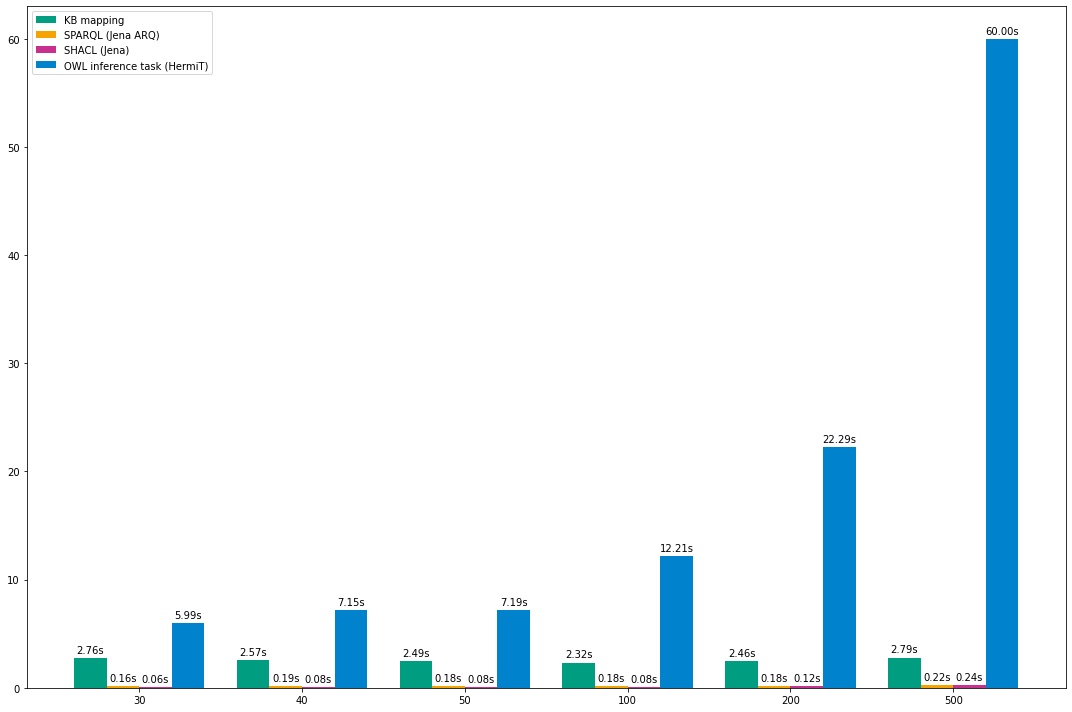

In [63]:
plotTaskTimeComparison(lowStore, ymax=None)

# High Range

500      2.803354
1500     3.283312
2500     3.911343
3500     4.916305
4500     5.572690
5500     6.875056
6500     7.264097
7500     8.470178
8500     9.397650
9500    12.095916
Name: times, dtype: float64

500     0.231579
1500    0.225039
2500    0.323689
3500    0.285503
4500    0.334228
5500    0.330418
6500    0.353789
7500    0.427583
8500    0.448908
9500    0.404647
Name: times, dtype: float64

500     0.182146
1500    0.320236
2500    0.351501
3500    0.537658
4500    0.551638
5500    0.662383
6500    0.687023
7500    0.867469
8500    0.875923
9500    0.908290
Name: times, dtype: float64

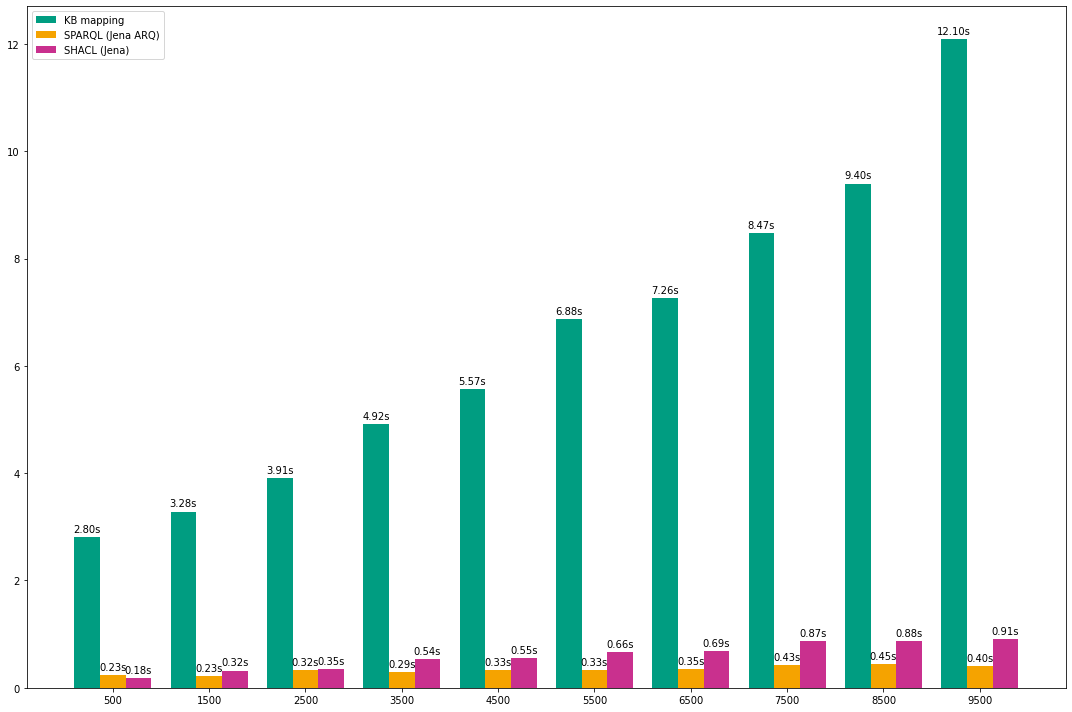

In [64]:
plotTaskTimeComparison(highStore, ymax=None)